# Report for the Continuous Control Project

By: Daniel Nehren
Date: 5/28/2020

The folowing report provides the details on the solution of the Continuous Control project.

The project task is to build an Agent to solve the Reacher Unity Environment. For the purpouses of this project solving the environment means obtaining an average of 30 points over 100 episodes. Every episode consists of 1000 steps as there is no end state

### Reacher Unity Environment Details:

In this environment, a double-jointed arm can move to target locations. A reward of +0.1 is provided for each step that the agent's hand is in the goal location. 
The observation space consists of 33 variables corresponding to position, rotation, velocity, and angular velocities of the arm. 
Each action is a vector with four numbers, corresponding to torque applicable to two joints. 
Every entry in the action vector should be a number between -1 and 1.

There are 2 separate environments:
- The first contains a single agent
- The second version contains 20 identical agents, each with its own copy of the environment.

Solving the environment consists in achieving an average score of 30 points over 100 episodes on single environment or an average of 30 points across all 20 agents for 100 episodes

### Learning Algorithm

The proposed agent is an version of a DDPG agent. 

#### Agent Details

The solution leverages the good PTAN library https://github.com/Shmuma/ptan to avoid creating a lot of boiler plate code and provide useful utilities to help with solving various RL problems.
Some of the implmentation details have been taken from the reference implementation of the DDPG algorithm provided for the book __Deeep Reinforcement learning Hands On__ https://www.packtpub.com/data/deep-reinforcement-learning-hands-on-second-edition

In order to use the PTAN library I had to implement a version of ExperienceSource and ExperienceSourceFirstLast that supports the Unity environment. This way I was able to use the ptan implementation of an efficien replay buffer.

The agent leveraged the _Actor_ network to general deterministic action values and adding a Ornstein–Uhlenbeck preocess to add exploration. The parameters of the noise process are the standard from literature:
```python
config.NOISE_THETA = 0.15
config.NOISE_SIGMA = 0.2
```

Ther actor uses a standard 3 layer network using Relu activation for internal layers and a tanh activation to ensure output is between -1 and +1
The  critic network uses the typical setup for DDPG with a standard input layer and the internal layer that contatenates both states and action decision to output the estimate of the Q function

The netwrok size are:
```python
config.ACTOR_FC1_UNITS = 128
config.ACTOR_FC2_UNITS = 64
config.CRITIC_FC1_UNITS = 128
config.CRITIC_FC2_UNITS = 64
```

The optimizers used for both networks is Adam with learning rates:
```python
config.LR_ACTOR = 1e-4
config.LR_CRITIC = 1e-4
```

We use target networks for both actor & critic. And they are updated via sof synch with:
```python
config.TAU = 1e-4
```

The replay buffer and batch sizes are as follows:
```python
config.BUFFER_SIZE = int(1e6)
config.BATCH_SIZE = 256
```

#### Training

We prime the buffer with 2000 experiences.
For every episode we run 1000 iteration in which we collect 20 experience and run one training step for each iteration.
At the end of each episode I execute on test run where I iterate for 1000 steps using the greedy output of the actor and collect the score for each agent and average it.

The training stops when the average over the last 100 episodes reaches 30


### Solution Details

The environmet was solved in 420 episodes with a maximum reward of 39.5 points for 1 episode.

In [1]:
%matplotlib inline

from unityagents import UnityEnvironment
import numpy as np
import pandas as pd
import sys
import torch
import ptan

import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Training Process Plots

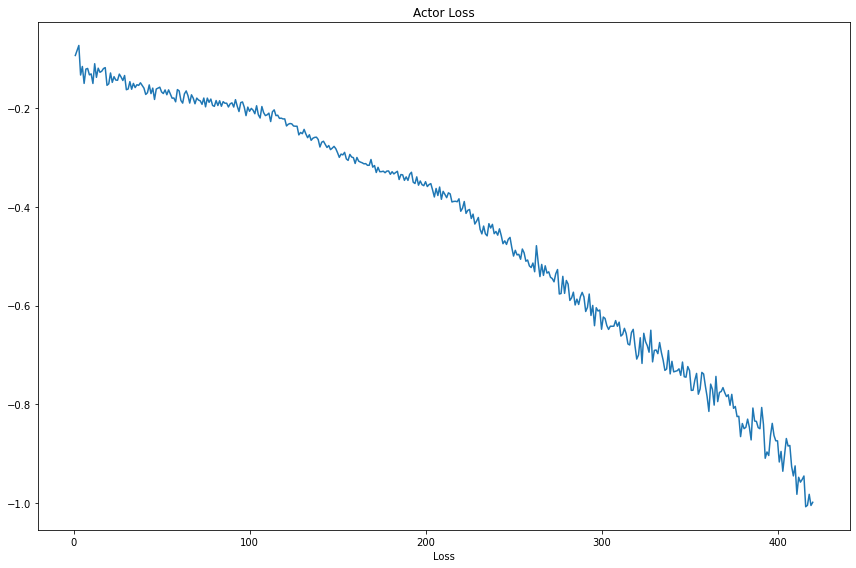

In [2]:
actor_loss = pd.read_csv('./loss_actor.csv')
actor_loss = actor_loss.set_index('Step')

fig, ax = plt.subplots(figsize=(12,8))
_ = actor_loss.Value.plot()
_ = plt.xlabel('Episode')
_ = plt.xlabel('Loss')
_ = plt.title('Actor Loss')
plt.tight_layout()
plt.show()

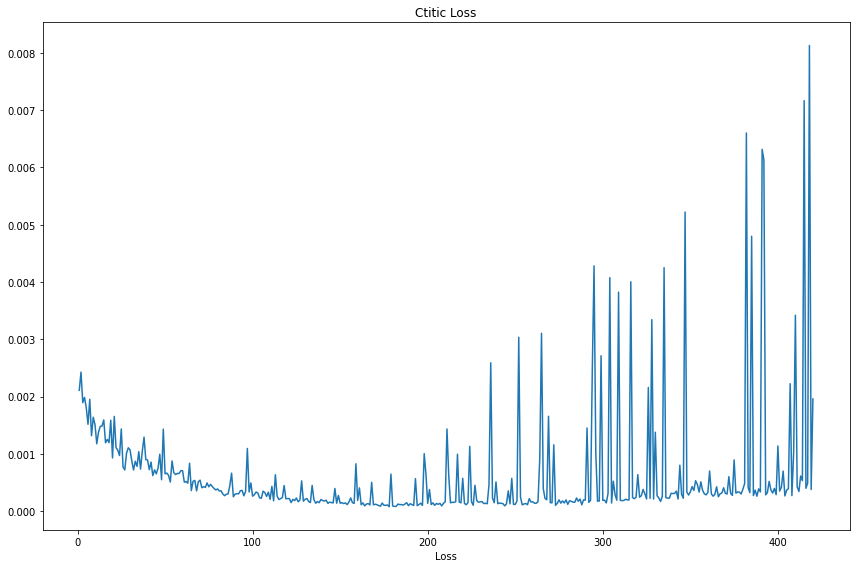

In [3]:
critic_loss = pd.read_csv('./loss_critic.csv')
critic_loss = critic_loss.set_index('Step')

fig, ax = plt.subplots(figsize=(12,8))
_ = critic_loss.Value.plot()
_ = plt.xlabel('Episode')
_ = plt.xlabel('Loss')
_ = plt.title('Ctitic Loss')
plt.tight_layout()
plt.show()

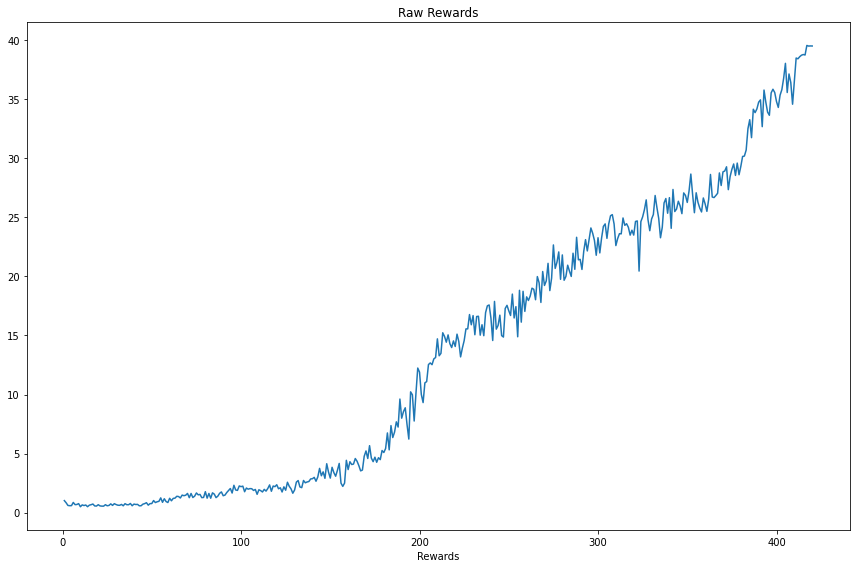

In [4]:
rewards_data = pd.read_csv('./reward.csv')
rewards_data = rewards_data.set_index('Step')

fig, ax = plt.subplots(figsize=(12,8))
_ = rewards_data.Value.plot()
_ = plt.xlabel('Episode')
_ = plt.xlabel('Rewards')
_ = plt.title('Raw Rewards')
plt.tight_layout()
plt.show()

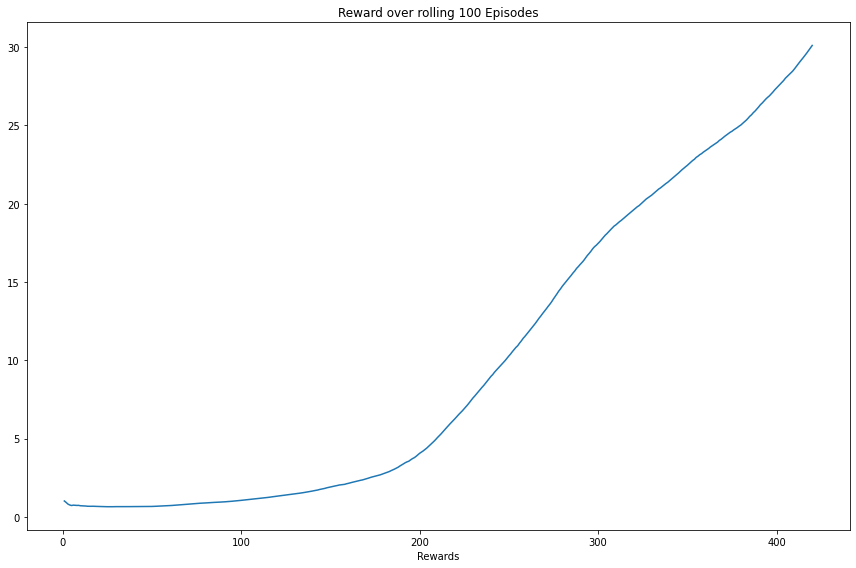

In [5]:
rewards100_data = pd.read_csv('./reward_100.csv')
rewards100_data = rewards100_data.set_index('Step')

fig, ax = plt.subplots(figsize=(12,8))
_ = rewards100_data.Value.plot()
_ = plt.xlabel('Episode')
_ = plt.xlabel('Rewards')
_ = plt.title('Reward over rolling 100 Episodes')
plt.tight_layout()
plt.show()

### Demonstrating Solution

In [6]:
sys.path.append('./')

In [7]:
from ddpg_model_ptan import AgentDDPG, DDPGActor,DDPGCritic,Config
from utils.experience_unity import UnityExperienceSourceFirstLast

In [8]:
env = UnityEnvironment(file_name='Reacher.app',no_graphics=False)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [9]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
state_size = brain.vector_observation_space_size
action_size = brain.vector_action_space_size

In [10]:
config = Config()

In [11]:
actor_net = DDPGActor(state_size,action_size,config.ACTOR_FC1_UNITS,config.ACTOR_FC2_UNITS)

In [12]:
model = torch.load('./learned_state.ckp')

In [13]:
actor_net.load_state_dict(model['actor'])

<All keys matched successfully>

In [14]:
agent = AgentDDPG(actor_net, device=config.device,ou_enabled=False)

In [15]:
max_steps = 1000
tot_rewards = []

env_info = env.reset(train_mode=True)[brain_name]

for run in range(5):

    total_reward = 0
    
    for t in range(max_steps):
        
        states_v = torch.from_numpy(env_info.vector_observations).float()
        
        with torch.no_grad():
            actions_v = actor_net(states_v)
            
        env_info = env.step(actions_v.detach().numpy())[brain_name]
        rewards = np.sum(env_info.rewards)
        total_reward += rewards
            
    tot_rewards.append(total_reward)
    
print(f'Mean reward over 5 runs:{np.mean(tot_rewards)}')

Mean reward over 5 runs:39.449999118223786


In [16]:
env.close()

### Ideas for Future Work

Looking at the agent perfroming in the enviroment with train_mode to False on can see that the environment is completely solved as the arm is constantly in the location zone for the full period. 
The solution also came relatively fast and from the critique and actor loss the evolution is quite stable.

That being said, in particular for more complex environments, with continuous action space there are several areas where we could explore:

1) Hyperparameter further exploration. There is room to explore more to accellerate convergence of the algorithm

2) The algorithm could be improved in several ways. In particular:

- Using N-step return for the critic
- Using a Prioritized Experience Replay Buffer

3) The literature also suggest that a better way to introduce exploration in the action space is to add adaptive (learned) noise to the actual actor network instead of adding OU Noise externally to the network

4) There are other algorithms that are more sample efficient like PPO that show promise. Additionally the fairly recent D4PG algorithm, an evolution of the DDPG algorithm which has shown state of the art performance on control tasks. https://arxiv.org/pdf/1804.08617.pdf 
